## IMPORT

In [1]:
#for data analysis and visualization
import pandas as pd
import numpy as np
%matplotlib inline 

#for model creation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,  ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_selection import RFE
import warnings
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import Lasso,Ridge,ElasticNet
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt


In [2]:
#concating 2 files to use test/train split

data = "https://raw.githubusercontent.com/HaniehRJP/Final-Project/main/customer_conversion_traing_dataset%20.csv"
df = pd.read_csv(data)
df_test_link='https://raw.githubusercontent.com/HaniehRJP/Final-Project/main/customer_conversion_testing_dataset.csv'
df_test=pd.read_csv(df_test_link)
df=pd.concat([df, df_test], axis=0)

## CLEANING

In [4]:
#NAs

def null_check(data_frame):
    print(f'Total null values per row: \n{data_frame.isnull().sum(axis=1)}\n')
    print(f'Total null values per column: \n{data_frame.isnull().sum()}\n')

null_check(df)

Total null values per row: 
0        0
1        0
2        0
3        0
4        0
        ..
26140    0
26141    0
26142    0
26143    0
26144    0
Length: 126145, dtype: int64

Total null values per column: 
LeadID                   0
Age                      0
Gender                   0
Location                 0
LeadSource               0
TimeSpent (minutes)      0
PagesViewed              0
LeadStatus               0
EmailSent                0
DeviceType               0
ReferralSource           0
FormSubmissions          0
Downloads                0
CTR_ProductPage          0
ResponseTime (hours)     0
FollowUpEmails           0
SocialMediaEngagement    0
PaymentHistory           0
Conversion (Target)      0
dtype: int64



In [5]:
#Duplicates check

def dup_check(data_frame):
    print(f'Duplicates found: {data_frame.duplicated().any()}\n')
    print(f'Number of duplicates: {data_frame.duplicated().sum()}\n')
    
dup_check(df)

Duplicates found: False

Number of duplicates: 0



In [6]:
#colmns optimization

#renaming
df.rename(columns={"TimeSpent (minutes)":"TimeSpent"}, inplace=True)
df.rename(columns={"Conversion (Target)":"Conversion"}, inplace=True)

#recalculating
df['ResponseTime'] = df['ResponseTime (hours)'] * 60

# Drop the original 'ResponseTime (hours)' column
# and columns that describe our actions that we will undertake aftr the predictionm as well as columns that added oise but havent had impact on the quality of the model
df.drop(columns=['ResponseTime (hours)', 'Location', 'ReferralSource', 'LeadStatus', 'LeadID', 'ResponseTime', 'SocialMediaEngagement'], inplace=True) 

In [7]:
df.to_csv('df.csv', index=False)

## ENCODING

In [8]:
categoricals = df.select_dtypes(include=[object, bool])
categoricals.head(3)

,Gender,LeadSource,DeviceType,PaymentHistory
0,Female,Referral,Desktop,No Payment
1,Female,Referral,Desktop,No Payment
2,Female,Referral,Tablet,No Payment


In [9]:
numericals = df.select_dtypes(include = 'number')
numericals.head(3)

,Age,TimeSpent,PagesViewed,EmailSent,FormSubmissions,CTR_ProductPage,FollowUpEmails,Conversion
0,60,30,13,1,4,0.3,10,0
1,27,28,4,7,2,0.3,3,0
2,21,45,10,9,4,0.6,8,0


In [10]:
ordinals = categoricals[['PaymentHistory']]
ordinals.head(3)

,PaymentHistory
0,No Payment
1,No Payment
2,No Payment


In [11]:
ordinals = categoricals['PaymentHistory'].map({'Good':1, 'No Payment':0})

In [12]:
nominals = categoricals.drop(columns=['PaymentHistory'])

In [13]:
nominals.head(3)

,Gender,LeadSource,DeviceType
0,Female,Referral,Desktop
1,Female,Referral,Desktop
2,Female,Referral,Tablet


In [14]:
#making dunnies from nominals

nominals = pd.get_dummies(nominals, dtype=int)
nominals.head()

,Gender_Female,Gender_Male,LeadSource_Email,LeadSource_Organic,LeadSource_Referral,LeadSource_Social Media,DeviceType_Desktop,DeviceType_Mobile,DeviceType_Tablet
0,1,0,0,0,1,0,1,0,0
1,1,0,0,0,1,0,1,0,0
2,1,0,0,0,1,0,0,0,1
3,1,0,1,0,0,0,1,0,0
4,0,1,0,0,1,0,0,0,1


In [15]:
categoricals = pd.concat([ordinals, nominals], axis=1)
categoricals.head()

,PaymentHistory,Gender_Female,Gender_Male,LeadSource_Email,LeadSource_Organic,LeadSource_Referral,LeadSource_Social Media,DeviceType_Desktop,DeviceType_Mobile,DeviceType_Tablet
0,0,1,0,0,0,1,0,1,0,0
1,0,1,0,0,0,1,0,1,0,0
2,0,1,0,0,0,1,0,0,0,1
3,1,1,0,1,0,0,0,1,0,0
4,0,0,1,0,0,1,0,0,0,1


In [16]:
df = pd.concat([categoricals, numericals], axis=1)
df.head(3)

,PaymentHistory,Gender_Female,Gender_Male,LeadSource_Email,LeadSource_Organic,LeadSource_Referral,LeadSource_Social Media,DeviceType_Desktop,DeviceType_Mobile,DeviceType_Tablet,Age,TimeSpent,PagesViewed,EmailSent,FormSubmissions,CTR_ProductPage,FollowUpEmails,Conversion
0,0,1,0,0,0,1,0,1,0,0,60,30,13,1,4,0.3,10,0
1,0,1,0,0,0,1,0,1,0,0,27,28,4,7,2,0.3,3,0
2,0,1,0,0,0,1,0,0,0,1,21,45,10,9,4,0.6,8,0


## TRAIN TEST SPLIT

In [17]:
#splitting into X and y
X=df.drop(columns=["Conversion"])
y=df[["Conversion"]]

In [18]:
#train and test split
X_train, X_test,y_train, y_test=train_test_split(X,y, random_state=42)

## DOWNSAMPLING

In [19]:
df_train=pd.concat([X_train, y_train], axis=1)
df_train

,PaymentHistory,Gender_Female,Gender_Male,LeadSource_Email,LeadSource_Organic,LeadSource_Referral,LeadSource_Social Media,DeviceType_Desktop,DeviceType_Mobile,DeviceType_Tablet,Age,TimeSpent,PagesViewed,EmailSent,FormSubmissions,CTR_ProductPage,FollowUpEmails,Conversion
84409,1,0,1,1,0,0,0,0,0,1,59,50,11,7,3,0.5,10,0
32618,0,0,1,1,0,0,0,1,0,0,45,9,15,9,5,0.8,8,1
71754,0,1,0,0,0,1,0,0,1,0,52,24,2,7,0,0.6,10,0
51225,1,1,0,0,0,0,1,0,1,0,23,29,8,4,0,0.2,10,0
54955,1,1,0,0,0,1,0,1,0,0,37,17,7,9,3,0.2,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19879,1,0,1,0,1,0,0,1,0,0,31,10,7,10,5,0.3,3,0
3694,1,1,0,0,0,0,1,0,1,0,42,8,12,10,1,0.8,8,0
860,1,0,1,0,1,0,0,0,0,1,59,33,11,7,2,0.2,10,0
15795,0,1,0,1,0,0,0,1,0,0,20,8,11,5,4,0.2,5,0


In [20]:
#downsampling
category_0 = df_train[df_train['Conversion'] == 0] # negative class (majority)
category_1 = df_train[df_train['Conversion'] == 1] # positive class (minority)

print(category_0['Conversion'].value_counts())
print(category_1['Conversion'].value_counts())

Conversion
0    93055
Name: count, dtype: int64
Conversion
1    1553
Name: count, dtype: int64


In [21]:
c1_len=5000
category_0_down = category_0.sample(c1_len)
print(category_0_down.shape)
print(category_1.shape)

(5000, 18)
(1553, 18)


In [22]:
# reassemble the data
df_train = pd.concat([category_0_down, category_1], axis=0)
# shuffle the data
df_train = df_train.sample(frac=1) # frac specifies ratio of the shuffled output to the input size. for frac=1 the number of rows is unchanged
df_train['Conversion'].value_counts()

Conversion
0    5000
1    1553
Name: count, dtype: int64

In [23]:
df_train

,PaymentHistory,Gender_Female,Gender_Male,LeadSource_Email,LeadSource_Organic,LeadSource_Referral,LeadSource_Social Media,DeviceType_Desktop,DeviceType_Mobile,DeviceType_Tablet,Age,TimeSpent,PagesViewed,EmailSent,FormSubmissions,CTR_ProductPage,FollowUpEmails,Conversion
15027,0,1,0,0,0,1,0,0,0,1,43,48,6,8,1,0.5,4,0
95806,1,0,1,0,0,1,0,0,1,0,60,27,10,10,4,0.2,9,0
15910,1,0,1,1,0,0,0,0,0,1,48,6,9,7,0,0.3,9,0
4647,0,1,0,1,0,0,0,0,1,0,58,21,9,6,3,0.1,8,0
90481,0,0,1,0,0,0,1,0,0,1,51,58,5,8,1,0.7,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36338,0,1,0,0,1,0,0,1,0,0,55,12,13,6,1,0.7,7,0
11112,0,0,1,0,1,0,0,0,1,0,42,10,15,6,3,0.6,4,1
11518,1,1,0,0,0,0,1,1,0,0,33,22,4,5,0,0.2,4,0
233,0,0,1,0,1,0,0,0,0,1,42,35,13,10,4,0.4,6,1


In [24]:
X_train=df_train.drop(columns=["Conversion"])
y_train=df_train[["Conversion"]]

## UPSAMPLE USING SMOTE

In [25]:
# Upsampling using SMOTE
smote = SMOTE()

In [26]:
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
y_train_sm.value_counts()

Conversion
0             5000
1             5000
Name: count, dtype: int64

## SCALING

In [27]:
#scaling
pt=PowerTransformer()
pt.fit(X_train)
X_train_pt=pt.transform(X_train_sm)
X_test_pt=pt.transform(X_test)

PowerTransformer()

## LOGISTICS REGRESSION

In [29]:
#fitting LOGISTICS REGRESSION

weights = {0: 1, 1: 2}
log_model = LogisticRegression(class_weight=weights) # weights to be added if we want to avoid fall negative or fall positive
log_model.fit(X_train_pt, y_train_sm)

# predicting data
y_pred_train = log_model.predict(X_train_pt)
y_pred_test = log_model.predict(X_test_pt)


#results
performance_log1 = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train_sm, y_pred_train),
                                         precision_score(y_train_sm, y_pred_train),
                                         recall_score(y_train_sm, y_pred_train)],
                               'Test': [accuracy_score(y_test, y_pred_test),
                                        precision_score(y_test, y_pred_test),
                                        recall_score(y_test, y_pred_test)]})

display(performance_log1)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(class_weight={0: 1, 1: 2})

,Error_metric,Train,Test
0,Accuracy,0.883900,0.818784
1,Precision,0.841123,0.070297
2,Recall,0.946600,0.840237


In [30]:
performance_log1.to_csv('LOGISTICS REGRESSION.csv', index=False)

## TRAIN SET CONFUSION MATRIX

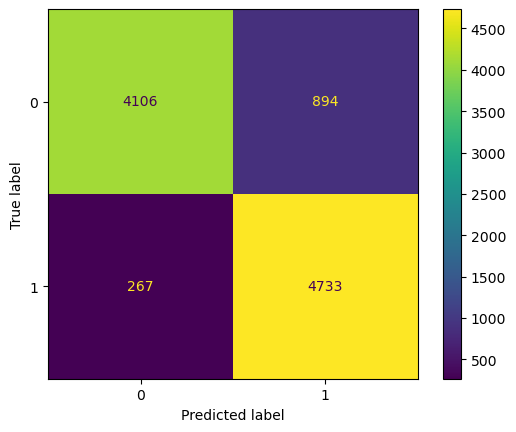

In [31]:
cm_train = confusion_matrix(y_train_sm, y_pred_train, labels = log_model.classes_)
disp = ConfusionMatrixDisplay(cm_train)
disp.plot()

## TEST SET CONFUSION MATRIX

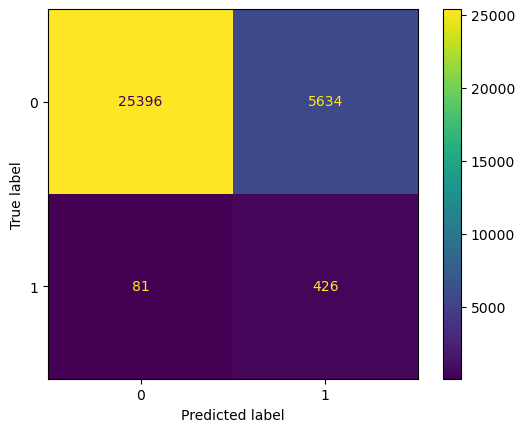

In [32]:
cm_train = confusion_matrix(y_test, y_pred_test, labels = log_model.classes_)
disp = ConfusionMatrixDisplay(cm_train)
disp.plot()

## Feature selection

In [33]:
# Filtering out DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)

accuracy = {}  # Dictionary to store best accuracies
precision = {} # Dictionary to store best precision
recall={} # Dictionary to store best recalls

# Iterating over different numbers of selected features
for num_features in range(10, 18):  # Considering up to 10 features
    
    selector = RFE(log_model, n_features_to_select=num_features, step=1, verbose=1)
    selector.fit(X_train_pt, y_train_sm)
    
    weights = {0: 1, 1: 2}
    log_model = LogisticRegression(class_weight=weights)
    
    # Transforming the data
    X_train_RFE = selector.transform(X_train_pt)
    X_test_RFE = selector.transform(X_test_pt)
    
    # Fitting the model
    log_model.fit(X_train_RFE, y_train_sm)
    
    # Predicting and calculating R2 score
    y_pred_test= log_model.predict(X_test_RFE)
    acc=accuracy_score(y_test, y_pred_test)
    rec=recall_score(y_test, y_pred_test)
    prec=precision_score(y_test, y_pred_test)
    
    # Storing the best R2 score for each number of selected features
    accuracy[num_features] = acc
    precision[num_features]=prec
    recall[num_features]=rec

# Printing the best R2 score for each number of selected features
for num_features, acc in accuracy.items():
    prec = precision[num_features]
    rec = recall[num_features]
    print(f"Number of Features: {num_features}, Accuracy: {acc}, Precision: {prec}, Recall: {rec}")

Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.
Fitting estimator with 11 features.


RFE(estimator=LogisticRegression(class_weight={0: 1, 1: 2}),
    n_features_to_select=10, verbose=1)

LogisticRegression(class_weight={0: 1, 1: 2})

Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.
Fitting estimator with 12 features.


RFE(estimator=LogisticRegression(class_weight={0: 1, 1: 2}),
    n_features_to_select=11, verbose=1)

LogisticRegression(class_weight={0: 1, 1: 2})

Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.
Fitting estimator with 13 features.


RFE(estimator=LogisticRegression(class_weight={0: 1, 1: 2}),
    n_features_to_select=12, verbose=1)

LogisticRegression(class_weight={0: 1, 1: 2})

Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.
Fitting estimator with 14 features.


RFE(estimator=LogisticRegression(class_weight={0: 1, 1: 2}),
    n_features_to_select=13, verbose=1)

LogisticRegression(class_weight={0: 1, 1: 2})

Fitting estimator with 17 features.
Fitting estimator with 16 features.
Fitting estimator with 15 features.


RFE(estimator=LogisticRegression(class_weight={0: 1, 1: 2}),
    n_features_to_select=14, verbose=1)

LogisticRegression(class_weight={0: 1, 1: 2})

Fitting estimator with 17 features.
Fitting estimator with 16 features.


RFE(estimator=LogisticRegression(class_weight={0: 1, 1: 2}),
    n_features_to_select=15, verbose=1)

LogisticRegression(class_weight={0: 1, 1: 2})

Fitting estimator with 17 features.


RFE(estimator=LogisticRegression(class_weight={0: 1, 1: 2}),
    n_features_to_select=16, verbose=1)

LogisticRegression(class_weight={0: 1, 1: 2})

RFE(estimator=LogisticRegression(class_weight={0: 1, 1: 2}),
    n_features_to_select=17, verbose=1)

LogisticRegression(class_weight={0: 1, 1: 2})

RFE(estimator=LogisticRegression(class_weight={0: 1, 1: 2}),
    n_features_to_select=18, verbose=1)

LogisticRegression(class_weight={0: 1, 1: 2})

RFE(estimator=LogisticRegression(class_weight={0: 1, 1: 2}),
    n_features_to_select=19, verbose=1)

LogisticRegression(class_weight={0: 1, 1: 2})

RFE(estimator=LogisticRegression(class_weight={0: 1, 1: 2}),
    n_features_to_select=20, verbose=1)

LogisticRegression(class_weight={0: 1, 1: 2})

Number of Features: 10, Accuracy: 0.7944636458762723, Precision: 0.06007951700780445, Recall: 0.8047337278106509
Number of Features: 11, Accuracy: 0.7905634651361892, Precision: 0.06028266512835304, Recall: 0.8244575936883629
Number of Features: 12, Accuracy: 0.8035323588166281, Precision: 0.06446179758076864, Recall: 0.8303747534516766
Number of Features: 13, Accuracy: 0.8129815771950407, Precision: 0.06851288618536898, Recall: 0.8441814595660749
Number of Features: 14, Accuracy: 0.8191964993499699, Precision: 0.07059018019507357, Recall: 0.8422090729783037
Number of Features: 15, Accuracy: 0.8185940324063798, Precision: 0.07051070840197693, Recall: 0.8441814595660749
Number of Features: 16, Accuracy: 0.818815993911913, Precision: 0.07059211611413492, Recall: 0.8441814595660749
Number of Features: 17, Accuracy: 0.8187842851254082, Precision: 0.0702970297029703, Recall: 0.8402366863905325
Number of Features: 18, Accuracy: 0.8187842851254082, Precision: 0.0702970297029703, Recall: 0.840

### best decision according to RFE is keeping all 20 features
##### Accuracy: 0.8187842851254082, Precision: 0.0702970297029703, Recall: 0.8402366863905325

## LASSO, RIDGE, ELASTICNET

- LASSO

In [34]:

# Initializing Logistic Regression model with Lasso regularization
log_model_lasso = LogisticRegression(penalty='l1', solver='liblinear', class_weight=weights)

# Fitting the model to your data
log_model_lasso.fit(X_train_pt, y_train_sm)

# Predicting on the test set
y_pred_lasso = log_model_lasso.predict(X_test_pt)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred_lasso)
precision = precision_score(y_test, y_pred_lasso)
recall = recall_score(y_test, y_pred_lasso)

# Printing evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

LogisticRegression(class_weight={0: 1, 1: 2}, penalty='l1', solver='liblinear')

Accuracy: 0.8192599169229794
Precision: 0.07047146401985112
Recall: 0.8402366863905325


- RIDGE

In [35]:

# Initializing Logistic Regression model with Lasso regularization
log_model_ridge = LogisticRegression(penalty='l2', solver='liblinear', class_weight=weights)

# Fitting the model to your data
log_model_ridge.fit(X_train_pt, y_train_sm)

# Predicting on the test set
y_pred_ridge = log_model_ridge.predict(X_test_pt)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred_ridge)
precision = precision_score(y_test, y_pred_ridge)
recall = recall_score(y_test, y_pred_ridge)

# Printing evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

LogisticRegression(class_weight={0: 1, 1: 2}, solver='liblinear')

Accuracy: 0.818562323619875
Precision: 0.07035755478662054
Recall: 0.8422090729783037


- ELASTICNET

In [36]:

# Initializing Logistic Regression model with Lasso regularization
log_model_elasticnet = LogisticRegression(penalty='elasticnet', solver='saga',l1_ratio=0.5, class_weight=weights)

# Fitting the model to your data
log_model_elasticnet.fit(X_train_pt, y_train_sm)

# Predicting on the test set
y_pred_elasticnet = log_model_elasticnet.predict(X_test_pt)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred_elasticnet)
precision = precision_score(y_test, y_pred_elasticnet)
recall = recall_score(y_test, y_pred_elasticnet)

# Printing evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

LogisticRegression(class_weight={0: 1, 1: 2}, l1_ratio=0.5,
                   penalty='elasticnet', solver='saga')

Accuracy: 0.8190062466309415
Precision: 0.07037832479762102
Recall: 0.8402366863905325


## Fit a KNN Classifier model 

In [37]:
# Instantiating KNN Classifier model

model = KNeighborsClassifier()

### Optimizing the Weighting Scheme for K-Nearest Neighbors (KNN)

In [38]:
# Defining a custom weight function

def custom_weight_function(distances):
    
    #Giving more weight to class 1
    
    weights = np.where(distances == 0, 5, 0.5)
    return weights

### Implementing Grid Searching for Number of Neighbors Optimization in KNN

In [39]:
# Defining the parameter grid for grid search and get the best model and fit the model

param_grid = {
    'n_neighbors': list(range(2, 21)),  # Range from 2 to 20
    'weights': [custom_weight_function, 'uniform', 'distance']
}

# Create the GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='recall')

# Fit the model
grid_search.fit(X_train_pt, y_train_sm)  # Assuming X_train and y_sm are your training data

# Print the best parameters
print("Best parameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# Now, best_model is the KNeighborsClassifier with the best hyperparameters
# You can use it for predictions on the test set
y_pred = best_model.predict(X_test)  # Assuming X_test is your test data


# Fit the model
model.fit(X_train_pt, y_train_sm)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
                                         14, 15, 16, 17, 18, 19, 20],
                         'weights': [<function custom_weight_function at 0x0000013E0D4B5D00>,
                                     'uniform', 'distance']},
             scoring='recall')

Best parameters: {'n_neighbors': 2, 'weights': 'distance'}


C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


KNeighborsClassifier()

In [40]:
# Instantiate KNN Classifier model
model = KNeighborsClassifier(n_neighbors=19,weights='distance')

# Fit the model
model.fit(X_train_pt, y_train_sm)


KNeighborsClassifier(n_neighbors=19, weights='distance')

### Predicting on the test and train set

In [41]:

y_pred = model.predict(X_test) # predict test
y_pred_train=model.predict(X_train_pt) # predict train (for sanity checks)

# Evaluate performance
performance_log = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train_sm, y_pred_train),
                                         precision_score(y_train_sm, y_pred_train),
                                         recall_score(y_train_sm, y_pred_train)],
                               'Test': [accuracy_score(y_test, y_pred_test),
                                        precision_score(y_test, y_pred_test),
                                        recall_score(y_test, y_pred_test)]})

display(performance_log)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


,Error_metric,Train,Test
0,Accuracy,1.0,0.818784
1,Precision,1.0,0.070297
2,Recall,1.0,0.840237


In [42]:
performance_log.to_csv('KNN.csv', index=False)

### TRAIN SET CONFUSION MATRIX

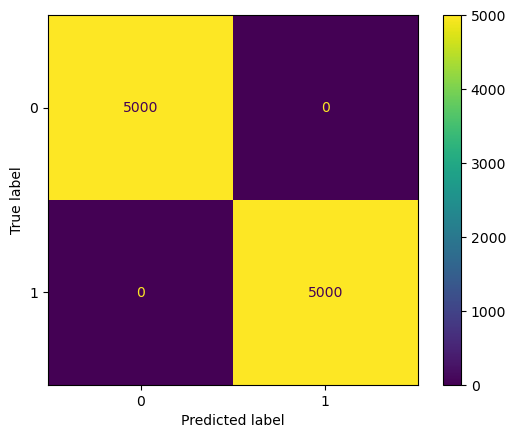

In [43]:
cm = confusion_matrix(y_train_sm, y_pred_train, labels= model.classes_)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

### TEST SET CONFUSION MATRIX

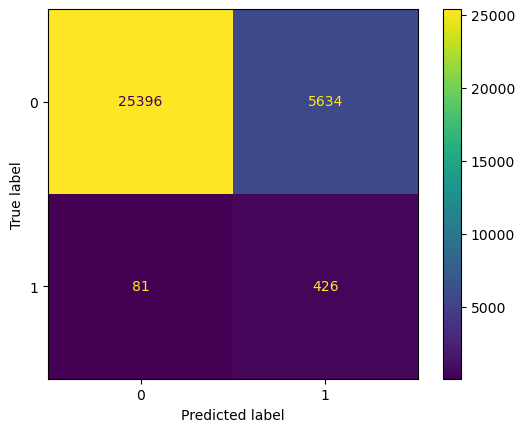

In [44]:
cm = confusion_matrix(y_test, y_pred_test, labels = model.classes_)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

## RandomForest Model

In [45]:
# for reproducible shuffling
RAND_STATE = 42

# test/train
TT_RATIO = 0.25 

In [46]:

rfc_ops = {"max_depth":6,
           "min_samples_leaf":20,
           "n_estimators":100,
           "bootstrap":True,
           "oob_score":True,
           "random_state":RAND_STATE}

class_weights = {0: 1, 1: 2}  # Adjust weights as needed
clf = RandomForestClassifier(class_weight=class_weights, **rfc_ops)

clf.fit(X_train_sm, y_train_sm)
print("train prediction accuracy score: %.2f" %(clf.score(X_train_sm, y_train_sm)))
print("test prediction accuracy score: %.2f"  %(clf.score(X_test, y_test)))

RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=6,
                       min_samples_leaf=20, oob_score=True, random_state=42)

train prediction accuracy score: 0.92
test prediction accuracy score: 0.84


In [47]:
# Utilizing Out-of-Bag Score for Performance Evaluation in RandomForestClassifier
clf.oob_score_

0.9209

In [48]:
#calculating the accuracy score of the model on the test set
score_ds = accuracy_score(y_test,clf.predict(X_test))
score_ds

0.8423756222849351

### Investigating Hyperparameter Tuning with Grid Search and Evaluating Results

In [49]:
# Creating the GridSearchCV object
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': list(range(2, 12)), 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(clf, param_grid, cv=5,return_train_score=True,n_jobs=-1)

# Fitting the model
grid_search.fit(X_train_sm,y_train_sm)  # Assuming X_train and y_sm are your training data

# Printing the best parameters
print("Best parameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

# predicting on the test set
y_pred = best_model.predict(X_test)  # Assuming X_test is your test data


# Fit the model
clf.fit(X_train_sm, y_train_sm)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0: 1, 1: 2},
                                              max_depth=6, min_samples_leaf=20,
                                              oob_score=True, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             return_train_score=True)

Best parameters: {'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


RandomForestClassifier(class_weight={0: 1, 1: 2}, max_depth=6,
                       min_samples_leaf=20, oob_score=True, random_state=42)

### Fitting a RandomForest Classifier with Optimized Max Depth

In [50]:
rfc_ops = {"max_depth":11,
           "min_samples_leaf":1,
           'min_samples_split': 2,
           "n_estimators":100,
           "oob_score":True,
           "random_state":42}

class_weights = {0: 2.5, 1: 1}  # Adjust weights as needed
clf = RandomForestClassifier(class_weight=class_weights, **rfc_ops)

        #max_depth=6,min_samples_leaf=20,max_features=None,n_estimators=100,
         #                    bootstrap=True,oob_score=True, random_state=RAND_STATE)
clf.fit(X_train_sm, y_train_sm)
print("train prediction accuracy score: %.2f" %(clf.score(X_train_sm, y_train_sm)))
print("test prediction accuracy score: %.2f"  %(clf.score(X_test, y_test)))


RandomForestClassifier(class_weight={0: 2.5, 1: 1}, max_depth=11,
                       oob_score=True, random_state=42)

train prediction accuracy score: 0.99
test prediction accuracy score: 0.93


### Predicting on the test and train set

In [51]:
# Predictions on the test set


y_pred = clf.predict(X_test) # predict test
y_pred_train=clf.predict(X_train_sm) # predict train (for sanity checks)

# Evaluate performance
performance_log2 = pd.DataFrame({'Error_metric': ['Accuracy','Precision','Recall'],
                               'Train': [accuracy_score(y_train_sm, y_pred_train),
                                         precision_score(y_train_sm, y_pred_train),
                                         recall_score(y_train_sm, y_pred_train)],
                               'Test': [accuracy_score(y_test, y_pred),
                                        precision_score(y_test, y_pred),
                                        recall_score(y_test, y_pred)]})

display(performance_log2)

,Error_metric,Train,Test
0,Accuracy,0.98550,0.928624
1,Precision,0.97292,0.169947
2,Recall,0.99880,0.885602


In [52]:
performance_log2.to_csv('RandomForest.csv', index=False)

### Visualizing Accuracy and Recall Performance Based on Max Depth

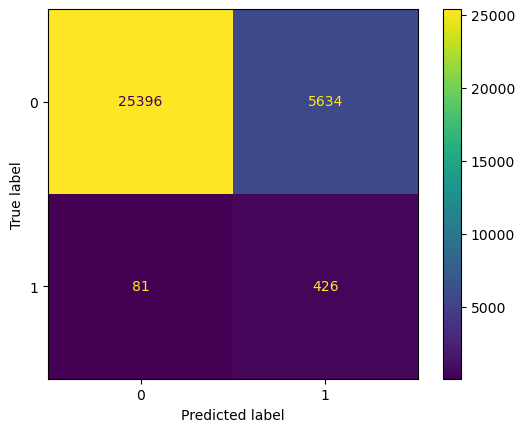

In [53]:
cm = confusion_matrix(y_test, y_pred_test, labels = clf.classes_)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [54]:
## USER INPUT

In [55]:
# ANSI escape codes for text formatting
class TextStyle:
    RESET = "\033[0m"
    BOLD = "\033[1m"
    UNDERLINE = "\033[4m"
    BLACK = "\033[30m"
    RED = "\033[31m"
    GREEN = "\033[32m"
    YELLOW = "\033[33m"
    BLUE = "\033[34m"
    MAGENTA = "\033[35m"
    CYAN = "\033[36m"
    WHITE = "\033[37m"
    BOLDBLACK = "\033[1m\033[30m"
    BOLDRED = "\033[1m\033[31m"
    BOLDGREEN = "\033[1m\033[32m"
    BOLDYELLOW = "\033[1m\033[33m"
    BOLDBLUE = "\033[1m\033[34m"
    BOLDMAGENTA = "\033[1m\033[35m"
    BOLDCYAN = "\033[1m\033[36m"
    BOLDWHITE = "\033[1m\033[37m"

In [56]:
def prediction_func():
    file_path = input("Enter the path or name of the CSV file: ")
    df_user=pd.read_csv(file_path)
    #renaming
    df_user.rename(columns={"TimeSpent (minutes)":"TimeSpent"}, inplace=True)
    df_user.rename(columns={"Conversion (Target)":"Conversion"}, inplace=True)

    #recalculating
    df_user['ResponseTime'] = df_user['ResponseTime (hours)'] * 60

    # Drop the original 'ResponseTime (hours)' column
    df_user.drop(columns=['ResponseTime (hours)', 'Location', 'ReferralSource', 'LeadStatus', 'LeadID', 'ResponseTime'], inplace=True)
    
    #encoding
    categoricals = df_user.select_dtypes(include=[object, bool])
    numericals = df_user.select_dtypes(include = 'number')
    ordinals = categoricals[['PaymentHistory']]
    ordinals = categoricals['PaymentHistory'].map({'Good':1, 'No Payment':0})
    nominals = categoricals.drop(columns=['PaymentHistory'])
    nominals = pd.get_dummies(nominals, dtype=int)
    categoricals = pd.concat([ordinals, nominals], axis=1)
    df_user_encoded = pd.concat([categoricals, numericals], axis=1)
    
    #adding the columns
    user_column=df_user_encoded.columns.tolist()
    column_list = df.columns.tolist()
    for column in column_list:
        if column  not in user_column:
            df_user_encoded[column]=0
    
    df_user.drop(columns=['Conversion'], inplace=True)
    
    # List the columns in the order of X_train
    columns_order = X_train.columns.tolist()

    # Reorder columns in df based on the order of columns_order
    df_user_encoded= df_user_encoded.reindex(columns=columns_order)
         
    y_pred = clf.predict(df_user_encoded)
    pred_df=pd.DataFrame(y_pred)
    final_df=pd.concat([df_user,pred_df], axis=1)
    final_df = final_df.rename(columns={0: 'Conversion_prediction'})
    k=0
    for i in y_pred:
        if i==1:
            k=1
    if k==0:
        print(TextStyle.BOLD + "No potential clients are in the list. No actions needed"+TextStyle.RESET)
    else:
        print(TextStyle.BOLD +"There are potential clients in your list. Contact them within 8 hours"+TextStyle.RESET)
    return final_df
        
    

In [ ]:
prediction_func()